# c_beta Analysis

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import linregress
import MolecularClocks.src.methylation_util as m_util
from MolecularClocks.src.invasiveCpGs_consts import getConsts

consts = getConsts()

sns.set(rc={"savefig.bbox":'tight'}, font_scale=1.2, style='white')

In [2]:
figure_outdir = 'figures'
if not os.path.exists(figure_outdir):
    os.mkdir(figure_outdir)

In [3]:
TCGA_clinical_dir = os.path.join(consts['official_indir'], 'TCGA')
TCGA_c_beta_dir = os.path.join(consts['repo_dir'], 'Select_fCpGs', 'outputs')
Ringner_clinical_dir = os.path.join(consts['official_indir'], 'Ringner')
Ringner_c_beta_dir = os.path.join(consts['repo_dir'], 'Process_Other_Data_Sources', 'outputs', 'cohort_T2')

In [4]:
clinical = {}

In [5]:
clinical['ringner'] = pd.read_table(os.path.join(Ringner_clinical_dir, 'cohort.T2.clinical.txt'), index_col=0, dtype={'grade':str})
clinical['ringner']['c_beta'] = pd.read_table(os.path.join(Ringner_c_beta_dir, 'cohort.T2.c_beta.txt'), index_col=0).squeeze("columns")
clinical['ringner'].name = 'Cohort T2'

In [6]:
clinical['TCGA'] = pd.read_table(os.path.join(TCGA_clinical_dir, 'cohort1.clinical.tsv'), index_col=0)
clinical['TCGA'] = clinical['TCGA'].set_index('bcr_patient_barcode')
c_beta_tcga = pd.read_table(os.path.join(TCGA_c_beta_dir, 'cohort.T1.c_beta.txt'), index_col=0, header=None).squeeze("columns")
c_beta_tcga.index = c_beta_tcga.index.to_series().apply(consts['sampleIDtoPatientID'])
clinical['TCGA']['c_beta'] = c_beta_tcga

clinical['TCGA']['T Stage'] = clinical['TCGA']['ajcc_pathologic_t'].dropna().apply(lambda x:x[:2])
clinical['TCGA']['Stage'] = clinical['TCGA']['ajcc_pathologic_stage'].dropna().str.rstrip('ABC')

In [7]:
marker_state_dict = {'Equivocal':'Positive', 'Indeterminate':float('NaN'),
                     'Negative':'Negative', 'Positive':'Positive'}
hormone_df = pd.read_table(os.path.join(TCGA_clinical_dir, 'nationwidechildrens.org_clinical_patient_brca.txt'),
                           usecols=['bcr_patient_barcode', 'her2_status_by_ihc', 'er_status_by_ihc', 'pr_status_by_ihc'],
                           index_col=0, na_values=['[Not Evaluated]', '[Not Available]']).iloc[2:]
hormone_df = hormone_df.apply(lambda col:col.map(marker_state_dict), axis=0)
# hormone_df.index = hormone_df.index.str.upper()
assert not hormone_df.index.duplicated().any()

In [8]:
# hormone_df.apply(lambda x:x.value_counts())
# hormone_df.loc[hormone_df['her2_status_by_ihc']=='Equivocal'].groupby('er_status_by_ihc')['pr_status_by_ihc'].value_counts().unstack()

In [9]:
clinical['TCGA'] = clinical['TCGA'].merge(hormone_df, left_index=True, right_index=True)

clinical['TCGA']['HR+'] = (clinical['TCGA']['er_status_by_ihc'] == 'Positive') | (clinical['TCGA']['pr_status_by_ihc'] == 'Positive')
clinical['TCGA']['HR-'] = (clinical['TCGA']['er_status_by_ihc'] == 'Negative') & (clinical['TCGA']['pr_status_by_ihc'] == 'Negative')

clinical['TCGA']['LumA_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')
clinical['TCGA']['LumB_type'] = clinical['TCGA']['HR+'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Positive')
clinical['TCGA']['Her2_type'] = (clinical['TCGA']['her2_status_by_ihc'] == 'Positive') & clinical['TCGA']['HR-']
clinical['TCGA']['Basal_type'] = clinical['TCGA']['HR-'] & (clinical['TCGA']['her2_status_by_ihc'] == 'Negative')


subtype_list = ['LumA_type', 'LumB_type', 'Her2_type', 'Basal_type']

for subtype in subtype_list:
    clinical['TCGA'][subtype] = clinical['TCGA'][subtype].map({True:subtype.split('_type')[0], False:''})

clinical['TCGA']['subtype'] = clinical['TCGA'][subtype_list].apply(lambda row:''.join(row), axis=1)
clinical['TCGA'].loc[clinical['TCGA']['subtype'] == '', 'subtype'] = None
clinical['TCGA'].name = 'Cohort T1'

0.9803386207552335
0.9503386207552336
0.9203386207552335


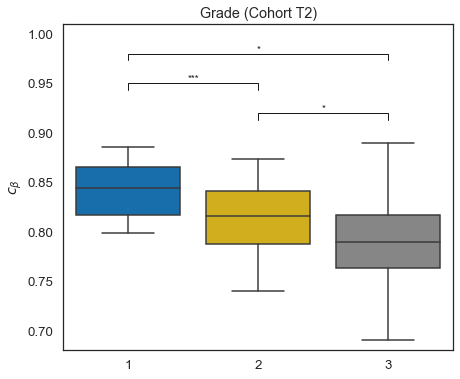

In [16]:
major_diagnoses = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS']

# sample_annotations = clinical['TCGA']
# var_cat = 'primary_diagnosis'
# use_groups=major_diagnoses
# restrict = False

sample_annotations = clinical['ringner']
var_cat = 'grade'
use_groups = None
restrict = True

# sample_annotations = clinical['ringner']
# var_cat = 'genefu.pam50.subtype'
# use_groups = ['LumA', 'LumB', 'Her2', 'Basal']
# restrict = True

# sample_annotations = clinical['TCGA']
# var_cat = 'T Stage'
# use_groups = ['T1', 'T2', 'T3', 'T4']
# restrict = True



var_y='c_beta'
x_size=7
y_size=6
outdir=figure_outdir
title=True
palette=consts['palette_jco']
starting_mask=None
label = None
plot_vertical = True
plot_ymax_mult=0.25
n_samples_label_text=0.15
n_samples_text=0.05

0.9548594848561864


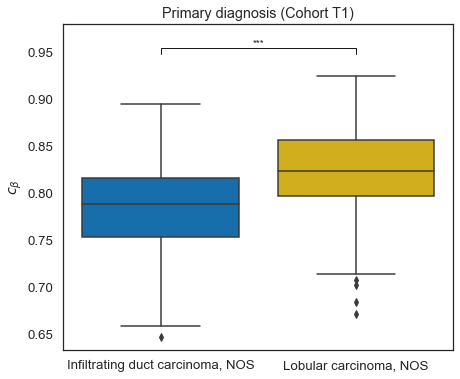

In [10]:
major_diagnoses = ['Infiltrating duct carcinoma, NOS', 'Lobular carcinoma, NOS']
m_util.saveBoxPlotNew(clinical['TCGA'], 'primary_diagnosis', restrict=False,
                   var_y='c_beta',
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True, use_groups=major_diagnoses,
                   palette=consts['palette_jco'])

In [30]:
figure_outdir

'figures'

0.9803386207552335
0.9503386207552336
0.9203386207552335


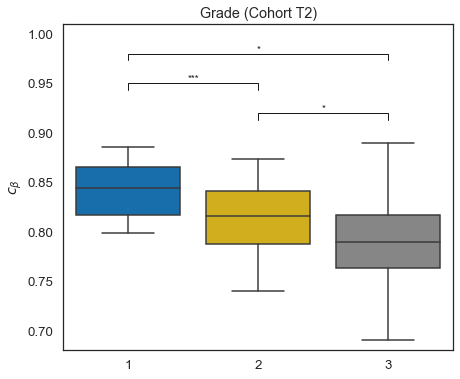

In [25]:
m_util.saveBoxPlotNew(clinical['ringner'], 'grade', restrict=True,
                   var_y='c_beta',
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

0.9254401482824056


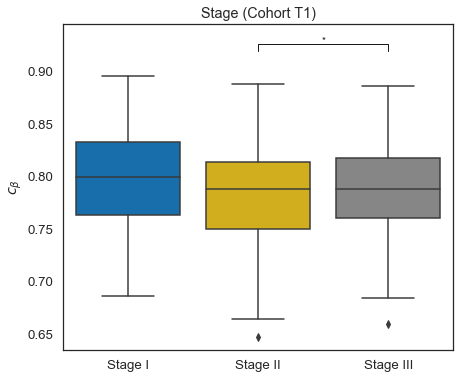

In [26]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'Stage', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Stage I', 'Stage II', 'Stage III'],
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

0.9198899399458389


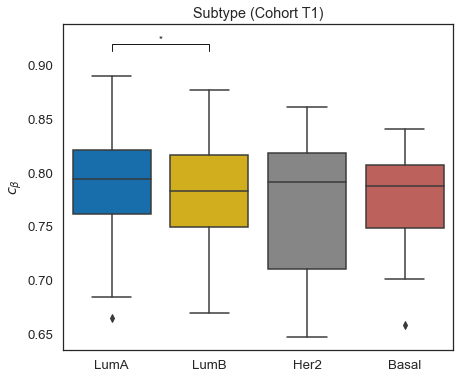

In [76]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype', restrict=True,
                   var_y='c_beta',
                      use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

0.9503386207552336
0.9203386207552335


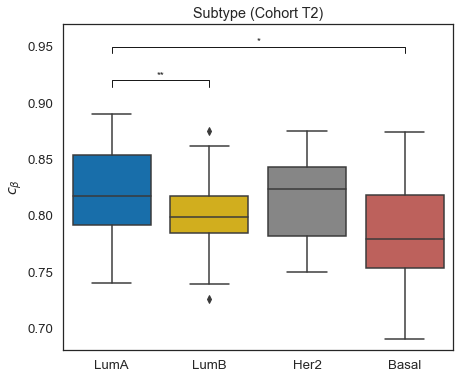

In [33]:
m_util.saveBoxPlotNew(clinical['ringner'], 'genefu.pam50.subtype', restrict=True,
                   var_y='c_beta',
                      use_groups = ['LumA', 'LumB', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

0.9554401482824055
0.9254401482824056


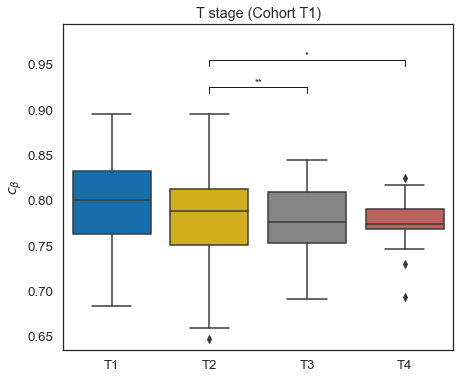

In [28]:
m_util.saveBoxPlotNew(clinical['TCGA'], 'T Stage', restrict=True,
                   var_y='c_beta',
                      use_groups = ['T1', 'T2', 'T3', 'T4'],
                   x_size=7, y_size=6,
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])


0.8898899399458389
0.9383966158264871


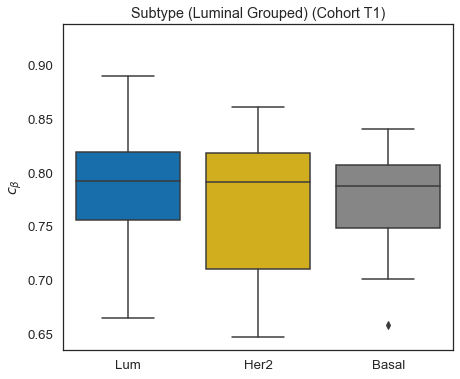

In [10]:
clinical['TCGA']['subtype_lumGrouped'] = clinical['TCGA']['subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['TCGA'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

0.8903386207552335
0.9702092017100028


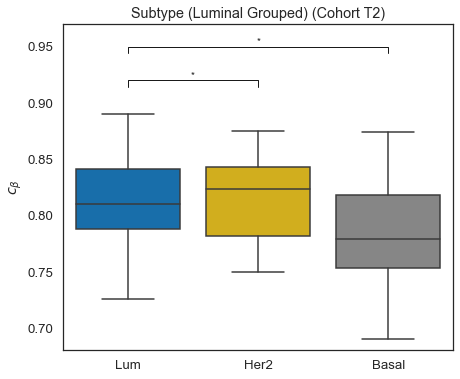

In [12]:
clinical['ringner']['subtype_lumGrouped'] = clinical['ringner']['genefu.pam50.subtype'].copy().map({'LumA':'Lum', 'LumB':'Lum', 'Her2':'Her2', 'Basal':'Basal'})

m_util.saveBoxPlotNew(clinical['ringner'], 'subtype_lumGrouped', restrict=True,
                   var_y='c_beta',
                      use_groups = ['Lum', 'Her2', 'Basal'],
                   x_size=7, y_size=6,
                      label = 'Subtype (Luminal Grouped)',
                   outdir=figure_outdir, title=True,
                   palette=consts['palette_jco'])

In [13]:
clinical['TCGA']['age'] = clinical['TCGA']['age_at_diagnosis'] / 365

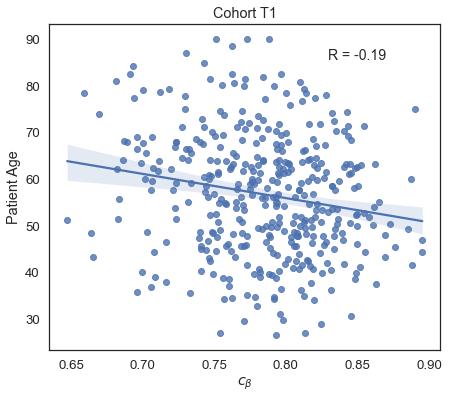

In [19]:
m_util.saveCorrelationPlot(clinical['TCGA'], var_y='age', restrict=True, outfile=False,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='Patient Age',
                           text_x=0.85, text_y=85, text_fontsize=14
                          )

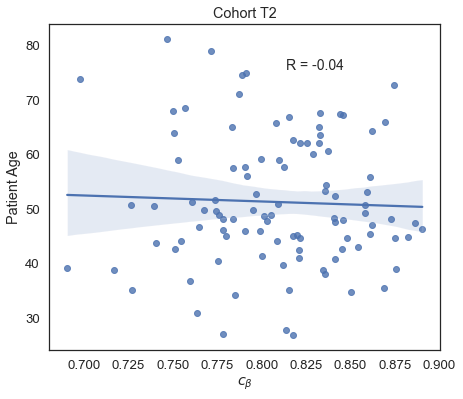

In [18]:
m_util.saveCorrelationPlot(clinical['ringner'], var_y='age', restrict=True, outfile=False,
                           outdir=figure_outdir,
                           x_size=7, y_size=6,
                           label='Patient Age',
                           text_x=0.83, text_y=75, text_fontsize=14
                          )